**Incendio Forestal**

Se busca desarrollar un modelo que simule un incendio forestal, en el cual se cuenta con un universo de arboles y rocas, los cuales estan distribuidos aleatoriamente en un terreno y al iniciar un fuego en un punto en específico este se va a propagar dependiendo de ciertos parámetros.

## Reglas

El universo (o entorno) del Incendio Forestal es finito, cuadrícula ortogonal bidimensional de celdas cuadradas, cada una de ellas se encuentra con uno de dos posibles estados, vivo o muerto (poblado o despoblado, respectivamente). Cada celda interactúa con ocho vecinos, que son las celdas adyacentes horizontales, verticales y diagonales. En cada paso de tiempo, las siguientes transiciones ocurren:

1. Cualquier celda viva con al menos un vecino quemado, se quema, ya que se propagó el fuego.
2. Cualquier celda viva con dos o tres vecinos vivos sobrevive para la siguiente generación.
3. Cualquier celda quemada se convierte en una roca para la siguiente generación.
4. Una vez terminado el fuego (que no exista ninguna celda quemada), cualquier celda que sea una roca se trasformará en un arbol (celda viva) para la siguiente generación con una probabilidad del 5%, debido a la reforestación.


El patrón inicial constituye la semilla del sistema. La primera generación es creada al aplicar las reglas anteriores de manera simultanea a cualquier celda en la semilla, viva o muerta; nacimientos y muertes ocurren simultáneamente, y el momento discreto en el cual esto pasa es a veces llamado turno. Cada generación es una función pura de la anterior. Las reglas se aplican de forma repetida para crear nuevas generaciones.

In [2]:
!python3 -m pip install mesa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.1/107.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Imports

Antes de empezar a crear el modelo del juego de la vida con multiagentes es necesario tener instalado los siguientes paquetes:
- `python`: asegúrense de usar la versión 3+.
- `mesa`: el framework de Python para el modelado de agentes.
- `numpy`: es una biblioteca de Python para el manejo de matrices, arreglos, manipulación matemática, lógica y mucho más.
- `matplotlib`: es una biblioteca para crear visualizaciones estáticas, animadas e interactivas en Python.

Para poder modelar el juego de la vida usando el framework de `mesa` es necesario importar dos clases: una para el modelo general, y otro para los agentes.

In [3]:
# 'Model' sirve para definir los atributos a nivel del modelo, maneja los agentes
# 'Agent' es la unidad atómica y puede ser contenido en múltiples instancias en los modelos
from mesa import Agent, Model

# 'SingleGrid' sirve para forzar a un solo objeto por celda (nuestro objetivo en este "juego")
from mesa.space import SingleGrid

# 'SimultaneousActivation' habilita la opción de activar todos los agentes de manera simultanea.
from mesa.time import SimultaneousActivation

# 'DataCollector' permite obtener el grid completo a cada paso (o generación), útil para visualizar
from mesa.datacollection import DataCollector

# 'matplotlib' lo usamos para graficar/visualizar como evoluciona el autómata celular.
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mlp
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
mlp.rcParams['animation.embed_limit'] = 2**128

# Definimos los siguientes paquetes para manejar valores númericos: 'numpy' & 'pandas'
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

## Crear el modelo

In [71]:
class ForestFireAgent(Agent):
    """
    Representa a un agente o una celda con estado vivo (1) o muerto (0)
    """
    def __init__(self, unique_id, model):
        """
        Crea un agente con estado inicial aleatorio de 0 ó 1, también se le asigna un identificador
        formado por una tupla (x,y). Se define un nuevo estado cuyo valor será definido por las
        reglas mencionadas arriba.
        """
        super().__init__(unique_id, model)
        self.live = np.random.choice([0, 1, 2], p=[0.01, 0.95, 0.04])  # 1% de 0, 95% de 1, 4% de 2
        self.next_state = None


    def step(self):
        """
        Este método es el que calcula si la celda vivirá o morirá dependiendo el estado de sus vecinos.
        Esta es la dinámica principal del juego de la vida. Por lo tanto, el estado live de la
        siguiente generación no se cambia aquí, solo se almacena en self.next_state. La idea consiste
        en esperar a que todos los agentes calculen su estado y una vez hecho esto, hacer el cambio.
        """

        neighbours = self.model.grid.get_neighbors(
            self.pos,
            moore=False,
            include_center=False)

        # live_neighbours = np.sum([neighbour.live for neighbour in neighbours])
        live_neighbours = 0
        for neighbor in neighbours:
            live_neighbours = live_neighbours + neighbor.live

        if self.live == 0:
            self.next_state = 2
        else:
            self.next_state = self.live

        if self.next_state == 1 and (live_neighbours < 4):
            self.next_state = 0

        # if self.next_state == 2 and np.random.random() < 0.01:
        #     self.next_state = 1
        if self.next_state == 2:
            # Verificar si hay algún estado 0 en el modelo
            zero_exists = any(agent.live == 0 for agent in self.model.schedule.agents)
            if not zero_exists and np.random.random() < 0.05:
                # Solo transformar a 1 si no hay estados 0 en el modelo
                self.next_state = 1


    def advance(self):
        """
        Define el nuevo estado calculado del método step.
        """
        self.live = self.next_state

class ForestFireModel(Model):
    """
    Define el modelo del juego de la vida.
    """
    def __init__(self, width, height):
        self.width = width
        self.height = height

        self.reset()

    def reset(self):
        self.num_agents = self.width * self.height
        self.grid = SingleGrid(self.width, self.height, True)
        self.schedule = SimultaneousActivation(self)

        # se importa arriba: import random
        # celdas = model.grid.coord_iter()
        # celdas_con_arboles = random.sample(celdas, k=25)
        # posiciones_arboles = [pos for _, pos in celdas_con_arboles]

        for (content, pos) in self.grid.coord_iter():
            # if pos in posiciones_arboles
                # código para instanciar árbol

            a = ForestFireAgent(pos, self)
            self.grid.place_agent(a, pos)
            self.schedule.add(a)

        # Aquí definimos el colector de datos para obtener el grid completo.
        self.datacollector = DataCollector(
            model_reporters={"Grid": self.get_grid,
                             "Live": self.get_live}
        )

    def step(self):
        """
        En cada paso el colector toma la información que se definió y almacena el grid para luego
        graficarlo.
        """
        self.datacollector.collect(self)
        self.schedule.step()

    def get_grid(self):
        """
        Esta es una función auxiliar que nos permite guardar el grid para cada uno de los agentes.
        :param model: El modelo del cual obtener el grid.
        :return: Matriz con la información del grid del agente.
        """

        # Generamos la grid para contener los valores
        grid = np.zeros((self.grid.width, self.grid.height))

        # Asignamos una celda a cada uno de los elementos de la grilla
        for cell in self.grid.coord_iter():
            cell_content, pos = cell
            x, y = pos
            grid[x][y] = cell_content.live

        return grid

    def get_live(self):
        total_live_agents = 0

        # Por todas las celdas del grid
        for cell in model.grid.coord_iter():
            agent, _ = cell
            if isinstance(agent, ForestFireAgent):
                total_live_agents += agent.live

        return total_live_agents

# Ejecución del modelo
A continuación corremos el modelo

In [72]:
# Definimos el tamaño del Grid ..> 7 x 7
GRID_SIZE = 100

# Definimos el número de generaciones a correr
NUM_GENERATIONS = 50

# Registramos el tiempo de inicio y corremos el modelo
start_time = time.time()

model = ForestFireModel(GRID_SIZE, GRID_SIZE)
for i in range(NUM_GENERATIONS):
    model.step()
final_time = time.time()

# Imprimimos el tiempo que le tomó correr al modelo.
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(final_time - start_time))))

Tiempo de ejecución: 0:03:23.103764


Obtenemos la información que almacenó el colector, este nos entregará un DataFrame de pandas que contiene toda la información.

In [73]:
all_grids = model.datacollector.get_model_vars_dataframe()

Graficamos la información usando `matplotlib`

In [74]:
all_grids

,Grid,Live
0,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",10284
1,"[[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0,...",10149
2,"[[1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0,...",10237
3,"[[1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 0.0, 1.0, 1.0,...",10662
4,"[[1.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 1.0,...",11308
5,"[[0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0,...",12155
6,"[[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0,...",13103
7,"[[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0,...",14051
8,"[[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0,...",14912
9,"[[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0,...",15730


In [75]:
%%capture

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7,7))

axs.set_xticks([])
axs.set_yticks([])

colors = []
# colors.append(np.array([255 / 255, 255 / 255, 40 / 255, 1])) # Yellow
colors.append(np.array([255 / 255, 80 / 255, 80 / 255, 1])) # Red
colors.append(np.array([120 / 255, 255 / 255, 120 / 255, 1])) # Green
colors.append(np.array([40 / 255, 40 / 255, 40 / 255, 1])) # Black
colormap = mlp.colors.ListedColormap(colors)

patch_grid = axs.imshow(all_grids['Grid'].iloc[0], cmap=colormap, vmin=0, vmax=2)

trees_alive = []
def animate(i):
    patch_grid.set_data(all_grids['Grid'].iloc[i])

    trees_alive.append(all_grids['Live'].iloc[i])

anim = animation.FuncAnimation(fig, animate, frames=NUM_GENERATIONS)

In [76]:
anim

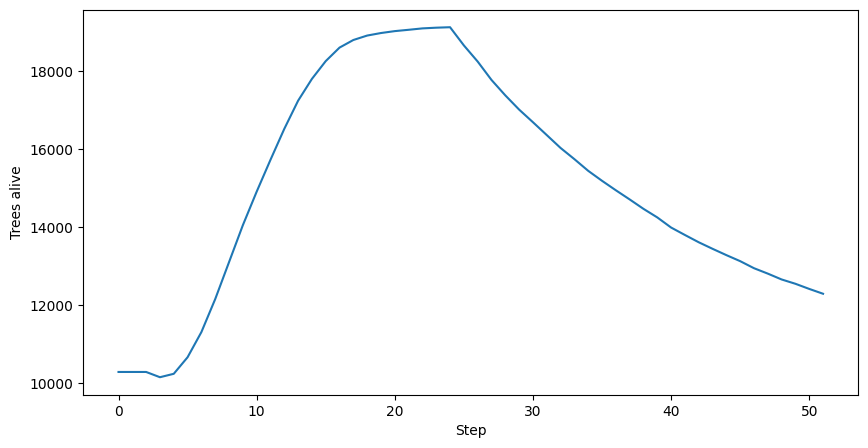

In [80]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

axs.set_xlabel("Step")
axs.set_ylabel("Trees alive")

plt.plot(trees_alive)
plt.show()

# Batch simulation

In [78]:
NUM_REPS = 100
GRID_SIZE = 10
NUM_GENERATIONS = 1000

model = ForestFireModel(GRID_SIZE, GRID_SIZE)

batch_data = dict(time=[], alive=[])
for _ in range(NUM_REPS):
    start_time = time.time()

    model.reset()
    for i in range(NUM_GENERATIONS):
        model.step()
    final_time = time.time()

    all_grids = model.datacollector.get_model_vars_dataframe()

    batch_data['time'].append(final_time - start_time)
    batch_data['alive'].append(all_grids['Live'].to_numpy())


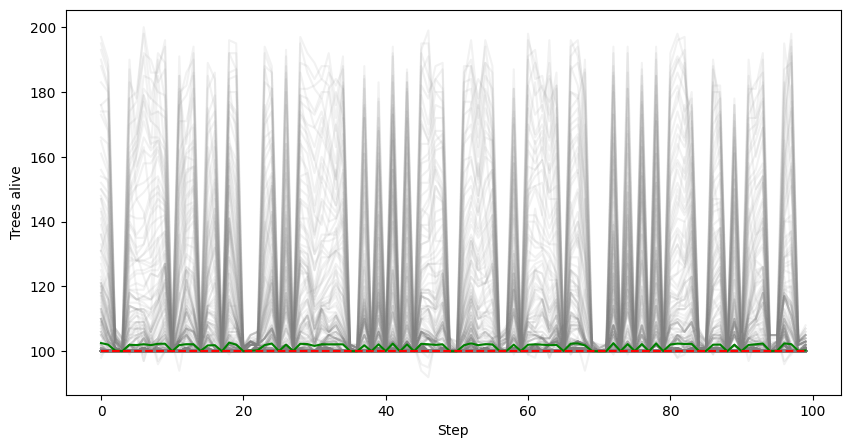

In [79]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

axs.set_xlabel("Step")
axs.set_ylabel("Trees alive")

#axs.set_prop_cycle('color', list(plt.cm.(np.linspace(0, 1, NUM_REPS))))
plt.plot(batch_data['alive'], color='Grey', alpha=0.1)

plt.plot(np.average(np.array(batch_data['alive']), axis=1), color='Green')
plt.plot(np.median(np.array(batch_data['alive']), axis=1), color='Red', linestyle='dashed')

plt.show()